In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
df_path = "c:/Users/Userpc/Desktop/Projects/ML Shortcuts/Data/smoking.csv"
df = pd.read_csv(df_path)

In [41]:
df.head()

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
2,Dead,Yes,71
3,Alive,No,67
4,Alive,No,64


In [42]:
def clean_data(dataf):
    return (dataf
            .assign(alive=lambda d: (d['outcome']=='Alive').astype(int))
            .assign(smokes=lambda d: (d['smoker']=='Yes').astype(int)))

In [43]:
cleaned_df = df.pipe(clean_data)
cleaned_df

,outcome,smoker,age,alive,smokes
0,Alive,Yes,23,1,1
1,Alive,Yes,18,1,1
2,Dead,Yes,71,0,1
3,Alive,No,67,1,0
4,Alive,No,64,1,0
...,...,...,...,...,...
1309,Alive,Yes,35,1,1
1310,Alive,No,33,1,0
1311,Alive,Yes,21,1,1
1312,Alive,No,46,1,0


In [44]:
cleaned_df.loc[lambda d: d['smokes'] == 1]['alive'].mean()

0.761168384879725

In [45]:
cleaned_df.loc[lambda d: d['smokes'] == 0]['alive'].mean()

0.6857923497267759

In [46]:
(cleaned_df
        .groupby(['smokes'])
        .agg(prob=('alive', np.mean)))

,prob
smokes,
0,0.685792
1,0.761168


<Axes: xlabel='age'>

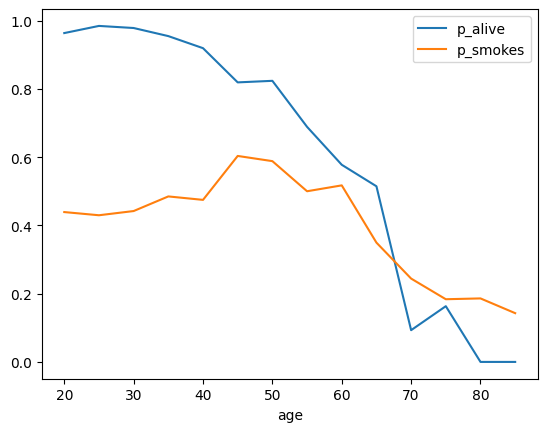

In [47]:
(cleaned_df
          .assign(age=lambda d: np.round(d['age'] / 5) * 5)
          .groupby(['age'])
          .agg(p_alive=('alive', np.mean),
               p_smokes=('smokes', np.mean))
          .plot()
        )

In [48]:
(cleaned_df
          .assign(age=lambda d: np.round(d['age'] / 10) * 10)
          .groupby(['age', 'smokes'])
          .agg(p=('alive', np.mean))
          .reset_index()
          .pivot(index='age',  columns='smokes', values='p')
          .assign(diff=lambda d: d[0] - d[1])
          ['diff'].mean()
        )

0.03449607015272389

In [49]:
df2 = pd.read_csv("c:/Users/Userpc/Desktop/Projects/ML Shortcuts/Data/sleep.csv")
df2.head()

,id,gpa,sleep,passed_unit_tests,passed_asserts,tackled_user_stories
0,1,23,normal,5,6,5
1,2,24,normal,1,3,2
2,3,23,normal,7,6,5
3,4,28,normal,5,8,4
4,5,25,normal,4,5,3


In [50]:
(df2
.groupby(['sleep'])
.agg(n=('id', 'count'),
     mean_unit_tests = ('passed_unit_tests', np.mean),
     mean_asserts = ('passed_asserts', np.mean),
     mean_user_stories = ('tackled_user_stories', np.mean)))

,n,mean_unit_tests,mean_asserts,mean_user_stories
sleep,,,,
deprived,15,1.133333,3.266667,1.600000
normal,21,2.904762,4.952381,2.714286


In [51]:
def reshuffle(dataf):
    return (dataf
                .sample(36)
                .reset_index(drop=True)
                .assign(sleep = lambda d: np.where(d.index < 15, 'deprived', 'normal')))

def calc_diff(dataf):
    agg = (dataf
            .groupby(['sleep'])
            .agg(mean_unit_tests = ('passed_unit_tests', np.mean),
                 mean_asserts = ('passed_asserts', np.mean),
                 mean_user_stories = ('tackled_user_stories', np.mean))).T
    return agg['deprived'] - agg['normal']

In [52]:
n = 1000
results = np.zeros((n, 3))
for i in range(n):
    results[i, :] = calc_diff(reshuffle(df2))

In [53]:
df_diff = pd.DataFrame(results, columns=[
    'diff_unit_tests',
    'diff_asserts',
    'diff_user_stories'
])

In [54]:
effect_dict = dict(calc_diff(df2))
effect_dict

{'mean_unit_tests': -1.7714285714285714,
 'mean_asserts': -1.685714285714286,
 'mean_user_stories': -1.1142857142857143}

In [55]:
agg = (df2
       .assign(gpa=lambda d: d['gpa'] < d['gpa'].mean())
       .groupby(['gpa'])
       .agg(mean_unit_tests = ('passed_unit_tests', np.mean),
            mean_asserts = ('passed_asserts', np.mean),
            mean_user_stories = ('tackled_user_stories', np.mean))).T

effect_dict = dict(agg[False] - agg[True])

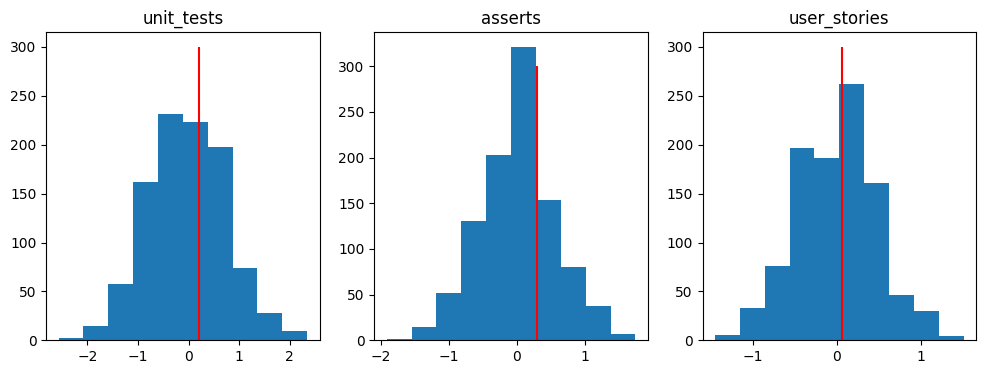

In [56]:
plt.figure(figsize=(12, 4))

for idx, name in enumerate(['unit_tests', 'asserts', 'user_stories']):
    plt.subplot(131 + idx)
    plt.hist(df_diff[f"diff_{name}"])
    plt.vlines(effect_dict[f"mean_{name}"], 0, 300, color='red')
    plt.title(name)

In [57]:
effect_dict

{'mean_unit_tests': 0.19480519480519476,
 'mean_asserts': 0.29220779220779214,
 'mean_user_stories': 0.05844155844155852}

In [58]:
df_diff.assign(limit=lambda d: d['diff_unit_tests'] < 0.194805)['limit'].mean()

0.635

In [59]:
df_diff.assign(limit=lambda d: d['diff_asserts'] < 0.292207)['limit'].mean()

0.723

In [60]:
df_diff.assign(limit=lambda d: d['diff_user_stories'] < 0.0584415)['limit'].mean()

0.59

In [63]:
df3 = pd.read_csv("c:/Users/Userpc/Desktop/Projects/ML Shortcuts/Data/birthdays.csv")
df3.head()

,state,year,month,day,date,wday,births
0,AK,1969,1,1,1969-01-01,Wed,14
1,AL,1969,1,1,1969-01-01,Wed,174
2,AR,1969,1,1,1969-01-01,Wed,78
3,AZ,1969,1,1,1969-01-01,Wed,84
4,CA,1969,1,1,1969-01-01,Wed,824


<Axes: xlabel='day_of_year'>

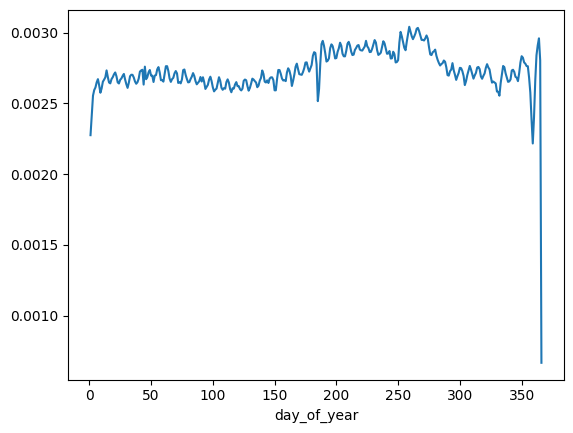

In [66]:
plot_df = (df3
                .assign(date=lambda d: pd.to_datetime(d['date']))
                .assign(day_of_year=lambda d: d['date'].dt.dayofyear)
                .groupby('day_of_year')
                .agg(n_births=('births', 'sum'))
                .assign(p=lambda d: d['n_births']/d['n_births'].sum()))
plot_df.head()
plot_df['p'].plot()